In [1]:
import numpy as np
import pylab as pl

# Contents

This notebook contains:
1. A simulation of the stochastic and deterministic ring model to illustrate attractor dynamics
1. An event-based simulated of a recurrent spiking network to illustrate low-dimensional dynamics 

# Part A: The ring model

Setting up the simulation paramters

In [2]:
dt  = 0.01  # Time-step for numerical integration
N   = 100   # Number of neurons
tau = 0.1   # Time constant of rate units

time = np.arange(0, 30, dt)
rates = np.zeros((len(time), N))

Setting up the connectivity matrix of the network as a difference of the von-Mises function. This is similar to a "mexican hat" on the ring.

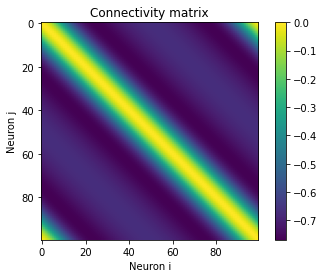

In [3]:
k1 = 3
k2 = 0.2
A = 100
M = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        th1 = 2*np.pi*i/N
        th2 = 2*np.pi*j/N
        M[i,j] = A*(np.exp(k1*(np.cos(th1-th2)-1)) - np.exp(k2*(np.cos(th1-th2)-1)))/N

pl.imshow(M)
pl.colorbar()
pl.xlabel("Neuron i")
pl.ylabel("Neuron j")
pl.title("Connectivity matrix");

With this connectivity matrix, run a simulation of the dynamics. To add stochasticity, coupling is made Poissonian. This will kick the bump arround the ring, resulting in a diffusive process.

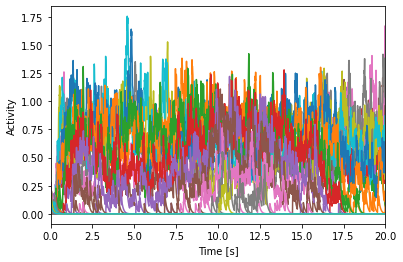

In [4]:
def phi(x):
    """
    This defined the activating nonlinearity. Here: just a rectifying linear function.
    """
    return x*(x>0)

alpha = dt/(dt+tau)
for t in range(1,len(time)):
    for unit in range(N):
        input_unit = phi( np.dot(M[unit,:], rates[t-1,:]) + 1)
#         rates[t, unit] = (1-alpha)*rates[t-1, unit] + alpha*input_unit 
        rates[t, unit] = (1-alpha)*rates[t-1, unit] + alpha*np.random.poisson(lam=np.abs(input_unit), size=None)       

pl.plot(time, rates);
pl.xlim([0,20])
pl.xlabel("Time [s]")
pl.ylabel("Activity");

Different way of plotting the same data.

<ipython-input-5-e132f913fdca>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pl.axes().set_aspect('equal')


Text(0.5, 1.0, 'Bump on ring')

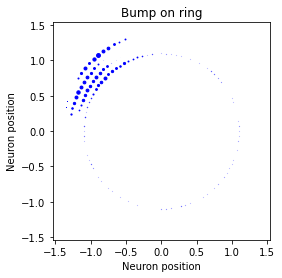

In [5]:
r = 1;
for t in [50, 200, 1000, 2000]:
    r = r + 0.1
    for i in range(N):
        th = 2*np.pi*i/N
        pl.scatter(r*np.cos(th), r*np.sin(th), 10*rates[t,i], 'b')

pl.axes().set_aspect('equal')
pl.xlabel("Neuron position")
pl.ylabel("Neuron position")
pl.title("Bump on ring")

# Part B: Poincare Section of RNN

Setting up parameters, and run as event-based simulation

In [6]:
tauM  = 0.1     # Time constant of the units
Ncalc = 100000  # Number of spikes simulated


# Some random connectivity matrix with few neurons.
A = np.array([[0, 0, 0, 0, 1], [1, 0, 1, 1, 0], [0, 1, 0, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 0, 0]])==1
N = len(A)

In [7]:
w = 1
C = -1
phi = np.pi*(2*np.random.rand(N,1)-1);
time = 0.

plotdata = np.zeros((Ncalc,3))
pcounter = 0

Run the simulation

In [8]:
for s in range(Ncalc):
    if np.mod(s, Ncalc/10) == 0:
        print(s*100/Ncalc)

    phiMax = np.max(phi) # find next spiking neuron j
    j      = np.argmax(phi)
    
    dt = (np.pi-phiMax)/w
    phi = phi + w*dt
    time = time + dt*tauM
    post = A[:,j]
    phi[post] = 2.*np.arctan(np.tan(phi[post]/2.) + C )
    phi[j] = - np.pi
    
    if j==0: # Safe the state whenever neuron "0" has fired
        plotdata[pcounter, :] = [phi[1], phi[2], phi[3]]
        pcounter = pcounter + 1;

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


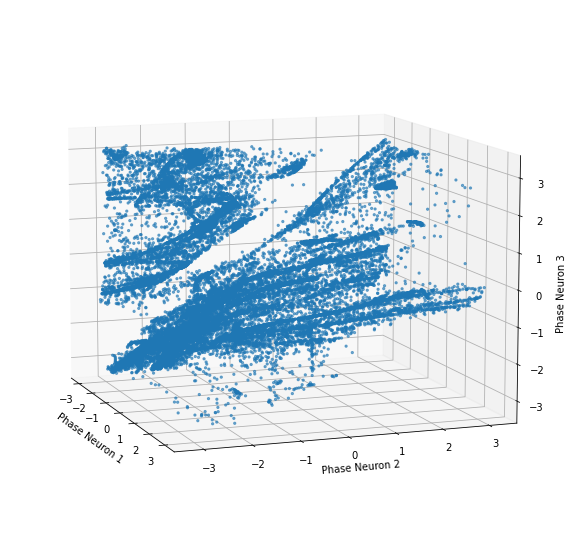

In [9]:
# Plot the result as a 3D scatterplot

fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=plotdata[:,0], ys=plotdata[:,1], zs=plotdata[:,2], marker = '.', alpha=0.6)
ax.view_init(elev=10., azim=-20)
ax.set_xlabel('Phase Neuron 1')
ax.set_ylabel('Phase Neuron 2')
ax.set_zlabel('Phase Neuron 3');